## Context

- the big picture question is what happens when you have multiple cytokines like IFNg, IL-4, IL-6
- We can see from other experiments that IFNg tends to dominate, but is it because other signals are insufficient or that IFNg overrides them ?
    - we know from textbooks that the cytokines of one module, including IFNg, tend to inhibit the differentiation of other clusters
- to test that, we've knocked out IFNgR with a CRISPR screen
- these are all tregs that have been adoptively transfered
- what we would like to do is a sort of 'subcluster' analysis where we subset the data on the knockout status and see if there are changes in the cell populations
    - for instance, we would be curious to see the Th1 population disappear and other populations to appear
    - while this may show up in the clustering, the populations are similar enough that that might not happen
    - so, we can settle on differential expression

- eric explained that in this case doublet detection is really important
- we can use CITE data to remove the doublets since each cell should only have one particular flavor of a pancell antibody stain
    - so, if any cell has two that should mean that we drop it

- this notebook is just preprocessing the data as well as mixscape analysis
- I do a little bit of clustering and DE gene analysis just to validate the preprocessing
- in PAL007, I go more in depth on the DE gene analysisi

## Libraries + Settings

In [2]:
import scanpy as sc
import pertpy as pt
import pandas as pd
import muon as mu
import pertpy as pt
from matplotlib import pyplot as plt
import plotnine as p9

In [3]:
%config InlineBackend.figure_format = 'retina'

## Data Import

In [4]:
mdata = mu.read_h5mu("/lustre/fs4/cao_lab/scratch/plaffont/personal_datasets/CTR02/ctr02.h5mu")
mdata

MuData object with n_obs × n_vars = 42903 × 32303
  var:	'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'target_gene_id', 'target_gene_name'
  3 modalities
    rna:	42903 x 32286
      var:	'gene_ids', 'feature_types', 'genome'
    guide:	42903 x 12
      var:	'gene_ids', 'feature_types', 'pattern', 'read', 'sequence', 'target_gene_id', 'target_gene_name'
    cite:	42903 x 5
      var:	'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence'

## Demultiplexing

- CD62 also known as L-selectin, is a resting marker, if you have it you're resting

In [5]:
ga = pt.pp.GuideAssignment()

In [6]:
mdata["cite"].X.toarray()

array([[3.1000e+01, 5.6000e+01, 3.0000e+01, 1.2118e+04, 3.5000e+01],
       [2.9000e+01, 1.2531e+04, 4.5000e+01, 1.0300e+02, 1.1000e+01],
       [2.6000e+01, 5.0790e+03, 4.5000e+01, 1.2200e+02, 9.0000e+00],
       ...,
       [2.4000e+01, 2.1500e+04, 4.3000e+01, 9.4000e+01, 3.2000e+01],
       [4.3160e+03, 3.8000e+01, 2.7000e+01, 6.8000e+01, 2.7000e+01],
       [7.5530e+03, 5.9000e+01, 7.0000e+01, 1.1900e+02, 2.1000e+01]],
      dtype=float32)

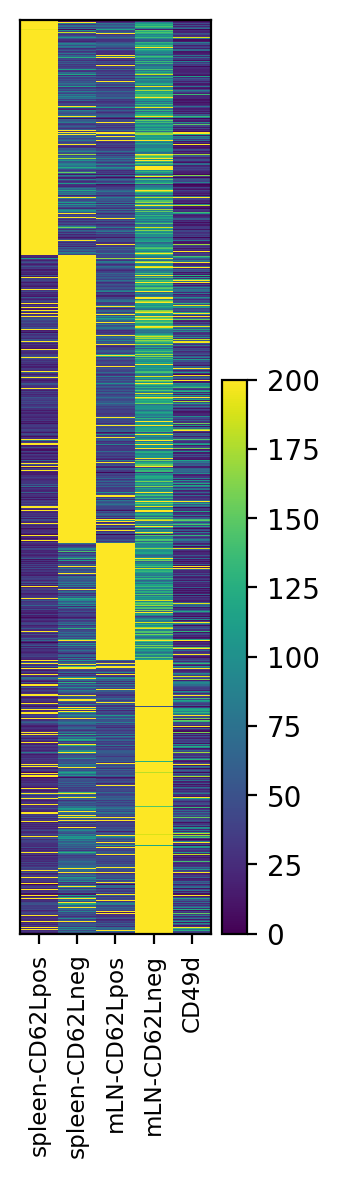

In [7]:
ga.plot_heatmap(mdata["cite"], vmax = 200)

- while this may look like substantial contamination, this is actually normal
- the background comes from chimeric PCR products see https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-019-5847-2
- in order to demultiplex, i'll use hashsolo

In [8]:
htos = mdata["cite"].var.index.unique()

htos = [hto for hto in htos if "CD49" not in hto]

for hto in htos:
    mdata["rna"].obs[hto] = mdata["cite"].X[:, mdata["cite"].var.index == hto].toarray() 

In [9]:
sc.external.pp.hashsolo(mdata["rna"], cell_hashing_columns=htos)

Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2


In [10]:
mask = (mdata["rna"].obs.Classification == "Doublet") | (mdata["rna"].obs.Classification == "Negative")
mu.pp.filter_obs(mdata, ~mask)

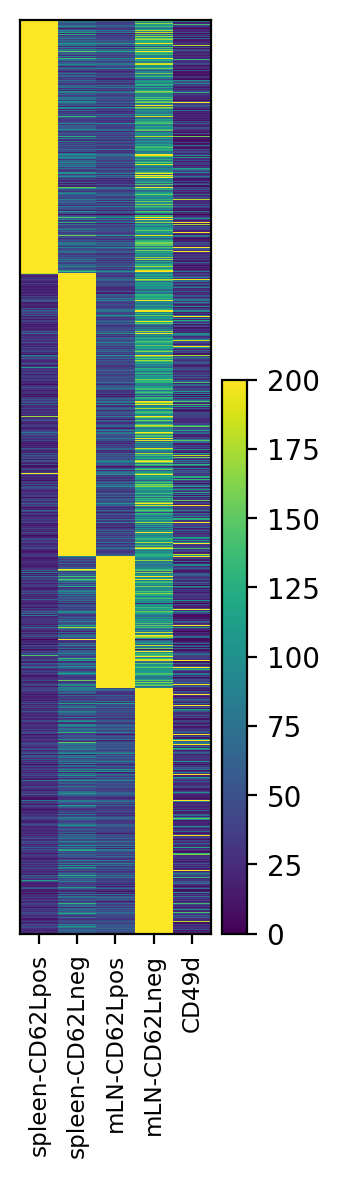

In [11]:
ga.plot_heatmap(mdata["cite"], vmax = 200)

## Mixscape modeling

- first let's add in the 10x perturbation calls

In [12]:
pt_df = pd.read_csv("/lustre/fs4/cao_lab/scratch/plaffont/personal_datasets/CTR02/protospacer_calls_per_cell.csv")

In [13]:
pt_df.set_index("cell_barcode", inplace = True)

In [14]:
mdata["rna"].obs = mdata["rna"].obs.join(pt_df)

- looks like ~5000 of the barcodes are not in the 10x readout

In [15]:
mask = mdata["rna"].obs.feature_call.isna()

mdata["rna"].obs[mask]

,spleen-CD62Lpos,spleen-CD62Lneg,mLN-CD62Lpos,mLN-CD62Lneg,most_likely_hypothesis,cluster_feature,negative_hypothesis_probability,singlet_hypothesis_probability,doublet_hypothesis_probability,Classification,num_features,feature_call,num_umis
AAACCATTCCTCCAGC-1,27.0,15047.0,38.0,115.0,1.0,0.0,4.144196e-15,1.000000,1.286469e-07,spleen-CD62Lneg,NaN,NaN,NaN
AAACCGACAAGTCGGG-1,23.0,37.0,59.0,16861.0,1.0,0.0,2.976061e-17,1.000000,4.244691e-16,mLN-CD62Lneg,NaN,NaN,NaN
AAACCGACACGGGTAG-1,12.0,23.0,14.0,8447.0,1.0,0.0,2.995274e-17,1.000000,8.640079e-16,mLN-CD62Lneg,NaN,NaN,NaN
AAACCGACAGCATGGG-1,1785.0,32.0,19.0,98.0,1.0,0.0,2.082251e-05,0.999979,5.041451e-08,spleen-CD62Lpos,NaN,NaN,NaN
AAACCGACAGGCTACC-1,32.0,9041.0,50.0,107.0,1.0,0.0,1.067880e-12,1.000000,8.401979e-08,spleen-CD62Lneg,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTTGTGCAGCGGTTTA-1,29.0,5451.0,37.0,125.0,1.0,0.0,3.282348e-10,1.000000,2.121801e-07,spleen-CD62Lneg,NaN,NaN,NaN
GTTGTGCAGGCCATAC-1,16.0,27.0,33.0,1278.0,1.0,0.0,1.386223e-06,0.999999,4.405244e-16,mLN-CD62Lneg,NaN,NaN,NaN
GTTGTGGGTAGCATCG-1,19.0,45.0,57.0,7799.0,1.0,0.0,1.399550e-15,1.000000,4.151928e-16,mLN-CD62Lneg,NaN,NaN,NaN
GTTGTGGGTCTGTTAT-1,4316.0,38.0,27.0,68.0,1.0,0.0,1.913708e-09,1.000000,6.651367e-09,spleen-CD62Lpos,NaN,NaN,NaN


- now let's drop the doubles

## drop cells with multiple guides

In [16]:
mask = ~mdata["rna"].obs.num_umis.str.contains("\|").fillna(True)

mu.pp.filter_obs(mdata, mask)

/tmp/ipykernel_60029/3268611832.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


In [17]:
# replace . with g for compatability with pertpy plotting functions
mdata["rna"].obs["feature_call"] = mdata["rna"].obs.feature_call.str.replace(".","g")

## Mixscape Modeling

- let's add in a column for the gene target 

In [18]:
mdata["rna"].obs["target"] = (
    mdata["rna"].obs
    .feature_call.str[:-2]
    .replace("NCC","NT")
    .replace("NTC","NT")
)

In [19]:
mdata["rna"].obs.head()

,spleen-CD62Lpos,spleen-CD62Lneg,mLN-CD62Lpos,mLN-CD62Lneg,most_likely_hypothesis,cluster_feature,negative_hypothesis_probability,singlet_hypothesis_probability,doublet_hypothesis_probability,Classification,num_features,feature_call,num_umis,target
AAACCAAAGACGTTAT-1,27.0,31.0,7020.0,89.0,1.0,0.0,1.862517e-11,1.000000,2.910459e-08,mLN-CD62Lpos,1.0,Tgfbr2g1,64,Tgfbr2
AAACCAAAGATGAAGC-1,21.0,37.0,6011.0,68.0,1.0,0.0,6.900368e-11,1.000000,6.651367e-09,mLN-CD62Lpos,1.0,NCCg1,313,NT
AAACCAAAGGTAGCTC-1,35.0,101.0,4388.0,179.0,1.0,0.0,1.111879e-09,0.999998,2.011029e-06,mLN-CD62Lpos,1.0,Ifngr1g4,44,Ifngr1
AAACCAGCAAAATCCC-1,37.0,7374.0,39.0,107.0,1.0,0.0,1.046450e-11,1.000000,8.401979e-08,spleen-CD62Lneg,1.0,Tgfbr2g1,58,Tgfbr2
AAACCAGCAAAGCTTC-1,33.0,42.0,6048.0,93.0,1.0,0.0,6.547057e-11,1.000000,3.734709e-08,mLN-CD62Lpos,1.0,Tgfbr2g1,43,Tgfbr2


### Preclustering

- mixscape requires dimensional reduction, so I'm going to do that here

In [20]:
rna = mdata["rna"]
rna

AnnData object with n_obs × n_vars = 17049 × 32286
    obs: 'spleen-CD62Lpos', 'spleen-CD62Lneg', 'mLN-CD62Lpos', 'mLN-CD62Lneg', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification', 'num_features', 'feature_call', 'num_umis', 'target'
    var: 'gene_ids', 'feature_types', 'genome'

In [21]:
rna.var["mt"] = rna.var_names.str.startswith("mt-")

sc.pp.calculate_qc_metrics(rna, inplace=True, log1p=False, percent_top=False, qc_vars="mt")

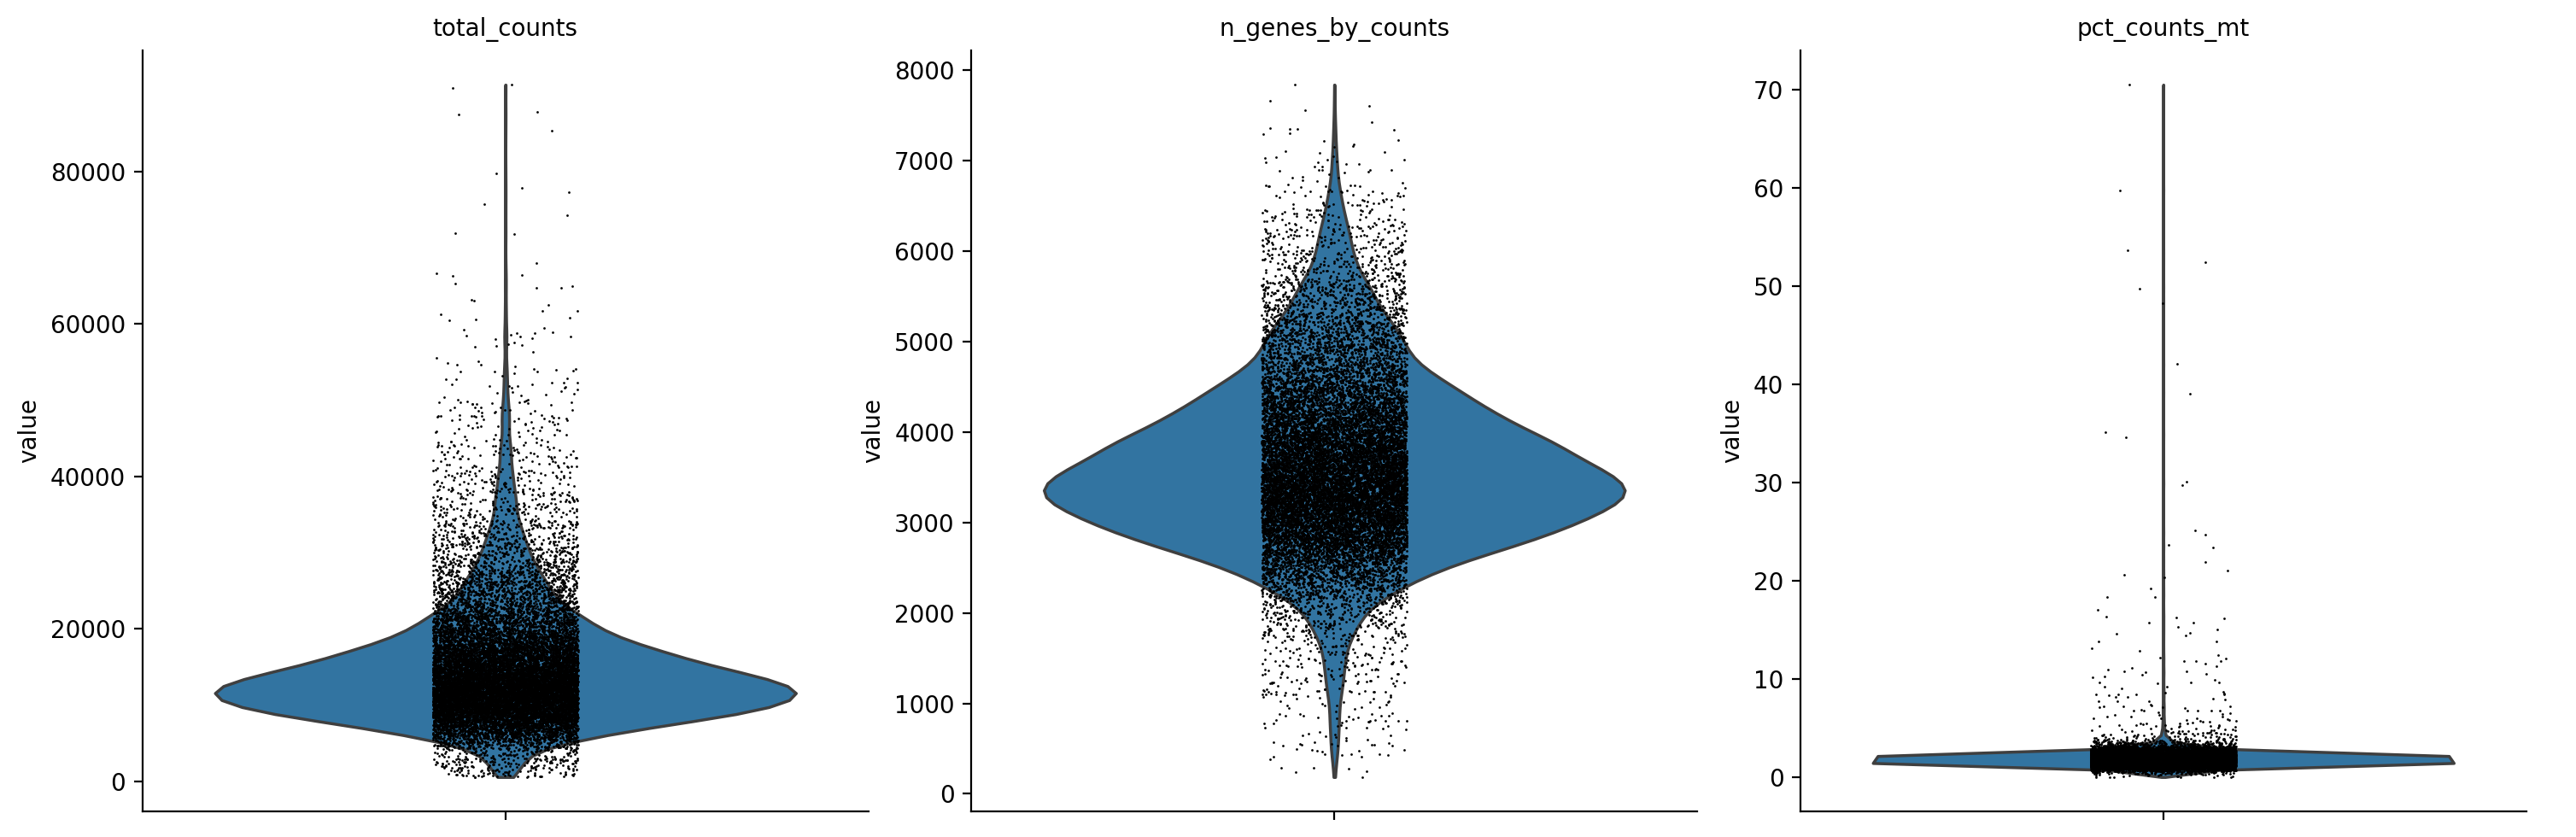

In [22]:
sc.pl.violin(rna, ["total_counts", "n_genes_by_counts", "pct_counts_mt"], multi_panel=True)

In [23]:
mu.pp.filter_obs(rna, "pct_counts_mt", lambda x: x < 20)

In [24]:
rna.layers["counts"] = rna.X.copy()

In [25]:
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna)

In [26]:
sc.pp.highly_variable_genes(rna)

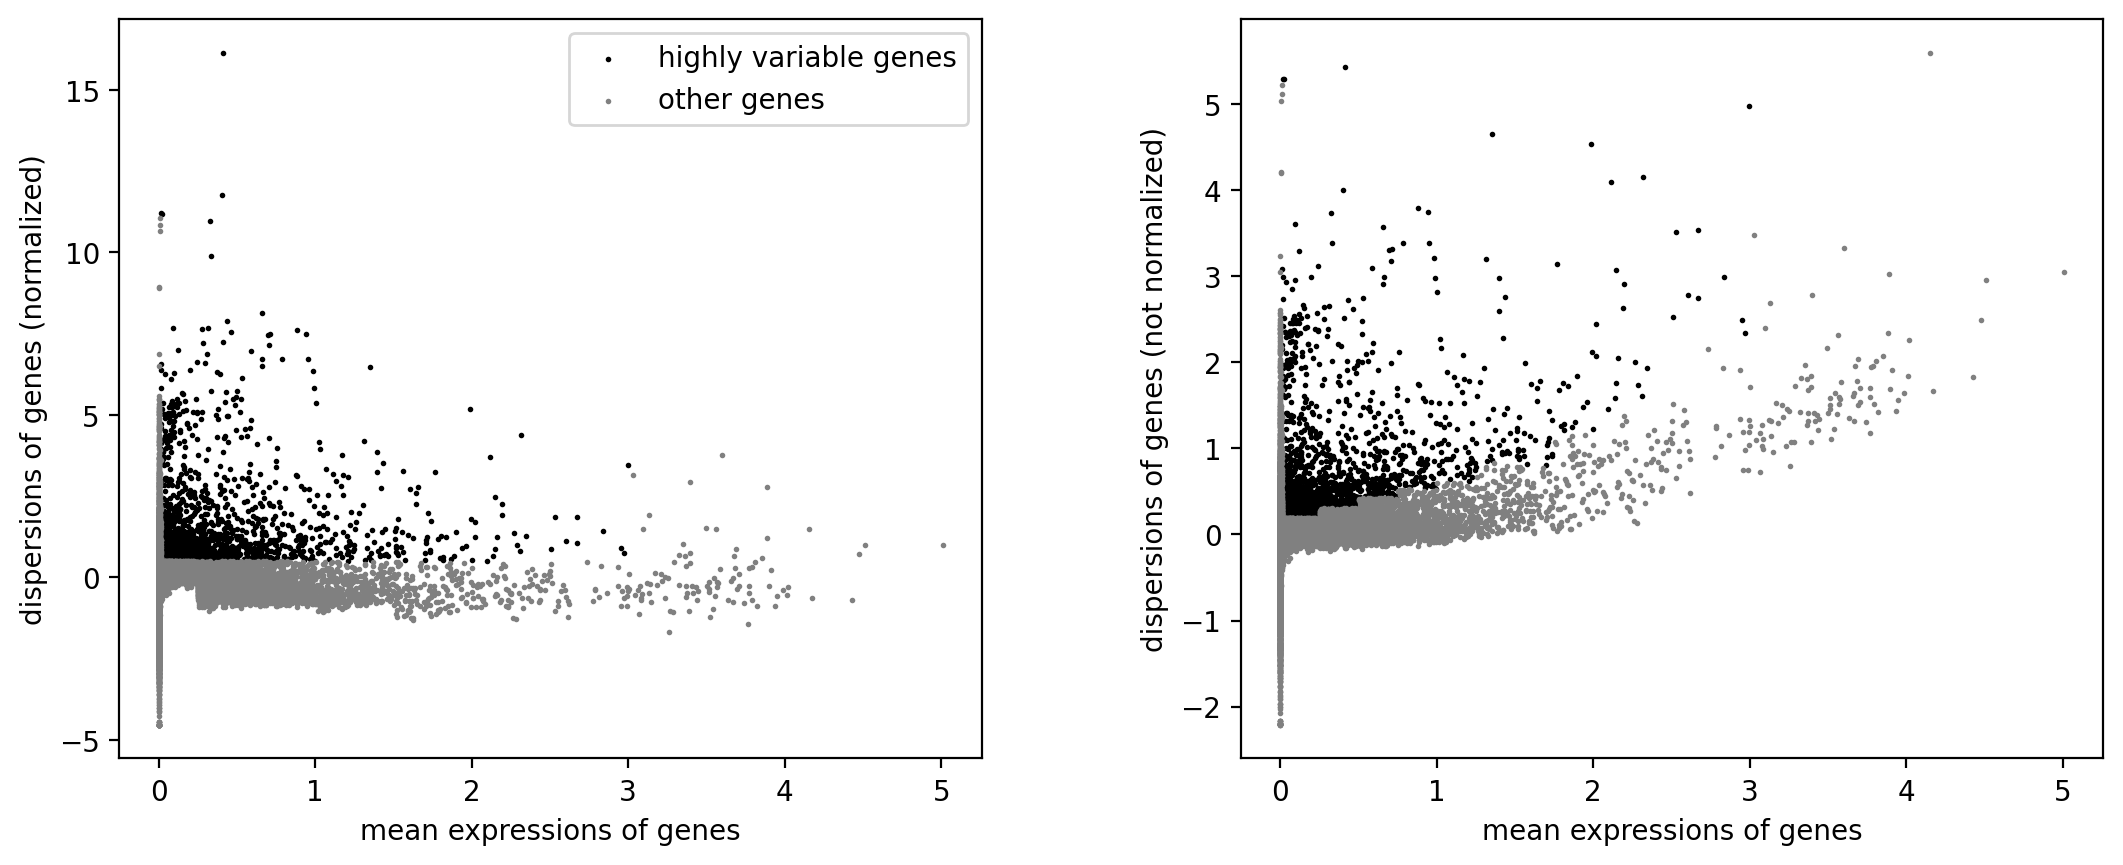

In [27]:
sc.pl.highly_variable_genes(rna)

In [28]:
sc.pp.scale(rna, max_value=10)

In [29]:
sc.pp.pca(rna)

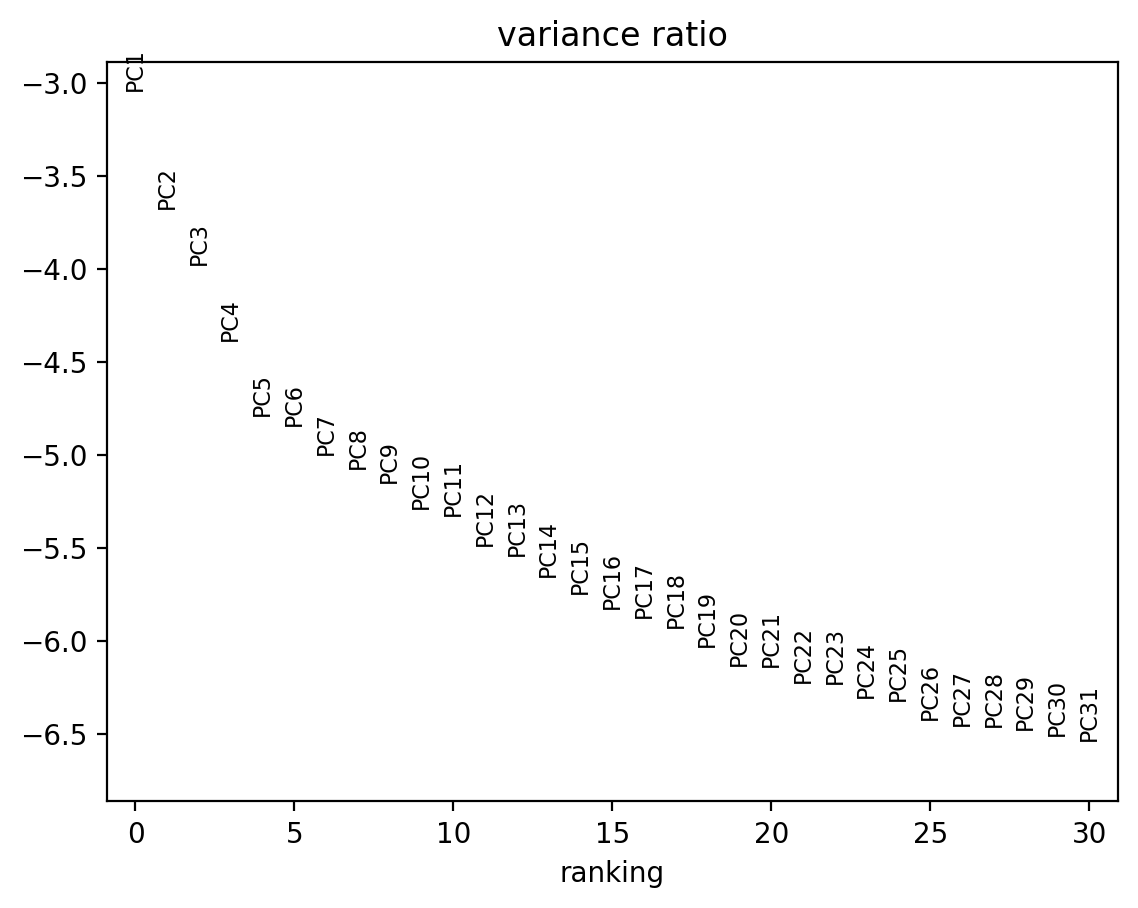

In [30]:
sc.pl.pca_variance_ratio(rna, log=True)

### Mixscape Call

In [31]:
ms = pt.tl.Mixscape()

In [32]:
ms.perturbation_signature(mdata["rna"], pert_key = "target", control="NT")

In [33]:
ms.mixscape(adata=mdata["rna"], control="NT", labels="target", layer="X_pert")

/lustre/fs4/cao_lab/store/plaffont/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
/lustre/fs4/cao_lab/store/plaffont/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2


<Axes: xlabel='mixscape_class'>

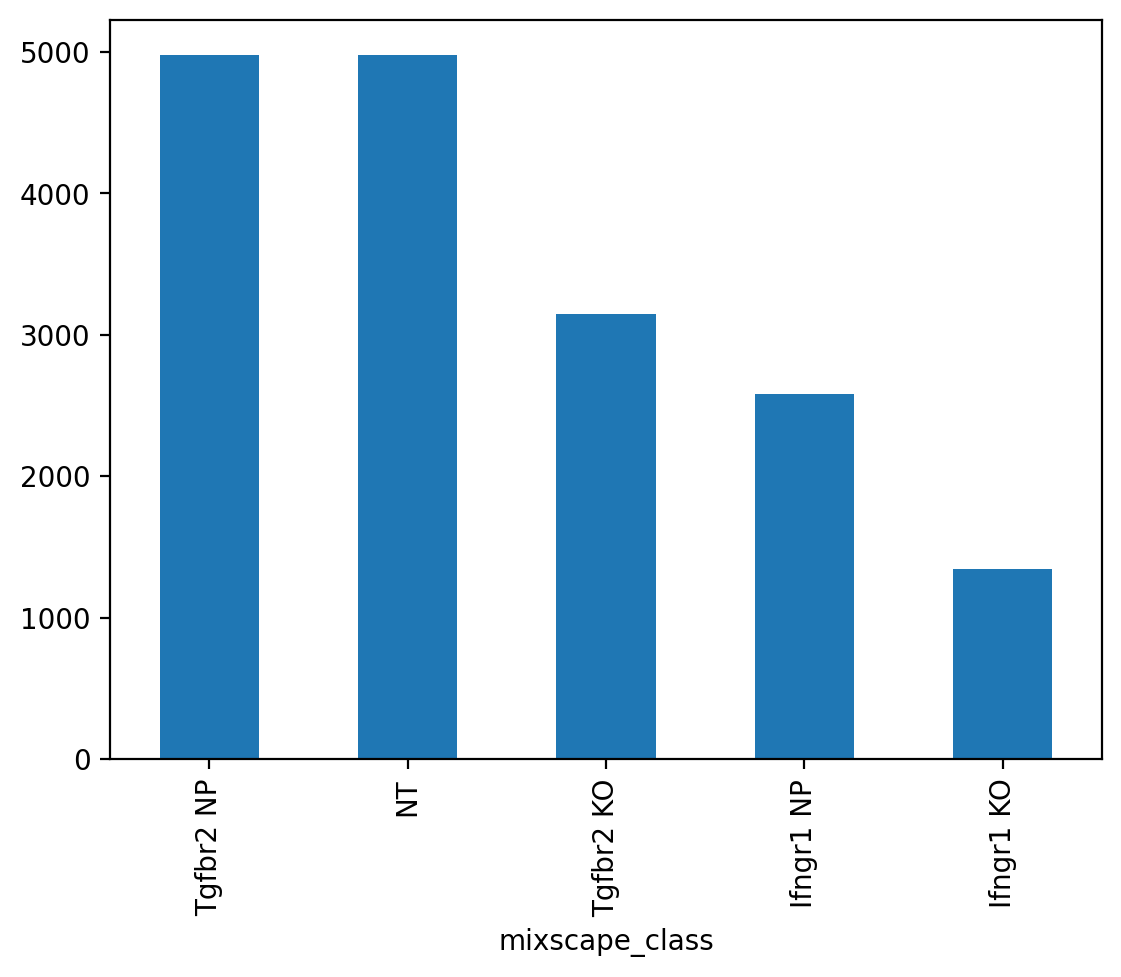

In [34]:
mdata["rna"].obs.mixscape_class.value_counts().plot.bar()

## Save Mixscape model

In [35]:
mdata.write("/lustre/fs4/cao_lab/scratch/plaffont/personal_datasets/CTR02/ctr02_processed.h5mu")

/lustre/fs4/cao_lab/store/plaffont/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/anndata/_core/anndata.py:1209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Plot Mixcape DE's

In [36]:
mdata["rna"].obs.head()

,spleen-CD62Lpos,spleen-CD62Lneg,mLN-CD62Lpos,mLN-CD62Lneg,most_likely_hypothesis,cluster_feature,negative_hypothesis_probability,singlet_hypothesis_probability,doublet_hypothesis_probability,Classification,...,feature_call,num_umis,target,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,mixscape_class_p_ko,mixscape_class,mixscape_class_global
AAACCAAAGACGTTAT-1,27.0,31.0,7020.0,89.0,1.0,0.0,1.862517e-11,1.000000,2.910459e-08,mLN-CD62Lpos,...,Tgfbr2g1,64,Tgfbr2,6195,45470.0,786.0,1.728612,1,Tgfbr2 KO,KO
AAACCAAAGATGAAGC-1,21.0,37.0,6011.0,68.0,1.0,0.0,6.900368e-11,1.000000,6.651367e-09,mLN-CD62Lpos,...,NCCg1,313,NT,4218,19019.0,306.0,1.608917,0,NT,NT
AAACCAAAGGTAGCTC-1,35.0,101.0,4388.0,179.0,1.0,0.0,1.111879e-09,0.999998,2.011029e-06,mLN-CD62Lpos,...,Ifngr1g4,44,Ifngr1,3007,12440.0,258.0,2.073955,1,Ifngr1 KO,KO
AAACCAGCAAAATCCC-1,37.0,7374.0,39.0,107.0,1.0,0.0,1.046450e-11,1.000000,8.401979e-08,spleen-CD62Lneg,...,Tgfbr2g1,58,Tgfbr2,4505,25348.0,408.0,1.609594,1,Tgfbr2 KO,KO
AAACCAGCAAAGCTTC-1,33.0,42.0,6048.0,93.0,1.0,0.0,6.547057e-11,1.000000,3.734709e-08,mLN-CD62Lpos,...,Tgfbr2g1,43,Tgfbr2,3482,13359.0,285.0,2.133393,0,Tgfbr2 NP,NP


categories: Ifngr1 KO, Ifngr1 NP, NT, etc.
var_group_labels: Ifngr1 KO, Ifngr1 NP, Tgfbr2 KO, etc.


/lustre/fs4/cao_lab/store/plaffont/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
/lustre/fs4/cao_lab/store/plaffont/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
/lustre/fs4/cao_lab/store/plaffont/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
/lustre/fs4/cao_lab/store/plaffont/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2


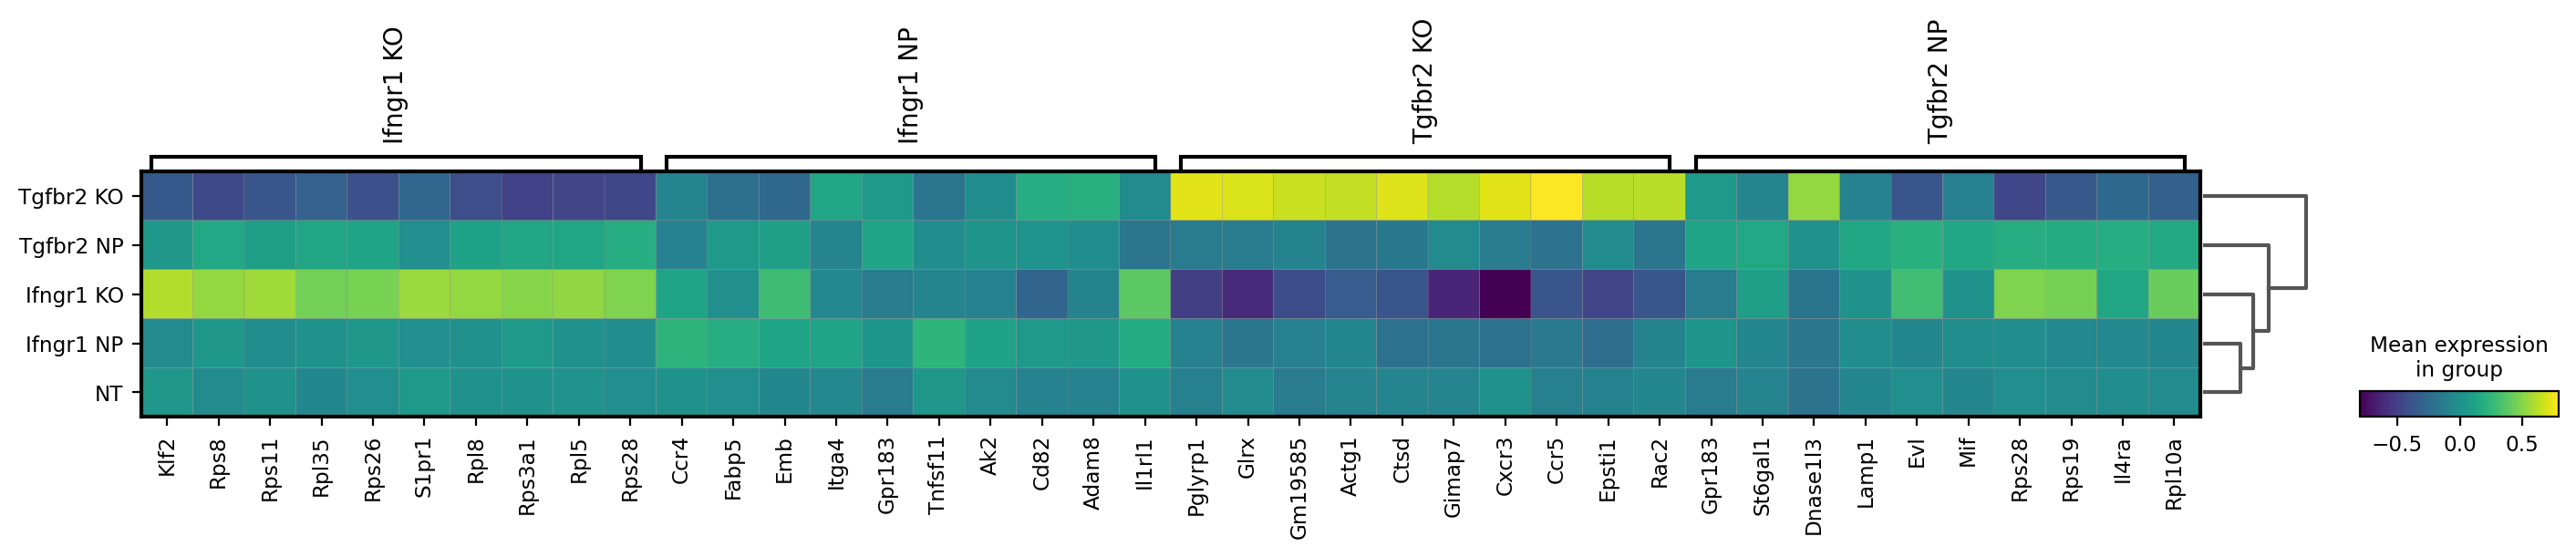

In [37]:
sc.tl.rank_genes_groups(mdata["rna"], groupby="mixscape_class", reference="NT")
sc.pl.rank_genes_groups_matrixplot(mdata["rna"], groupby="mixscape_class")

## Subset on KO

In [38]:
ko_rna = rna[rna.obs.mixscape_class_global == "KO", :]

In [39]:
ko_rna.var_names

Index(['Xkr4', 'Gm1992', 'Gm19938', 'Gm37381', 'Rp1', 'Sox17', 'Gm37587',
       'Gm37323', 'Mrpl15', 'Lypla1',
       ...
       'AC163611.1', 'AC163611.2', 'AC140365.1', 'AC124606.2', 'AC124606.1',
       'AC133095.2', 'AC133095.1', 'AC234645.1', 'AC149090.1', 'pSL21-VEX'],
      dtype='object', length=32286)

In [40]:
sc.pp.highly_variable_genes(ko_rna, min_mean=0.02, max_mean=4, min_disp=0.5)
sc.pp.scale(ko_rna, max_value=10)
sc.tl.pca(ko_rna, svd_solver='arpack')
sc.pp.neighbors(ko_rna, n_neighbors=10, n_pcs=25)
sc.tl.leiden(ko_rna, resolution=.7)
sc.tl.umap(ko_rna, spread=1., min_dist=.5, random_state=11)

/lustre/fs4/cao_lab/store/plaffont/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:305: RuntimeWarning: invalid value encountered in log
/lustre/fs4/cao_lab/store/plaffont/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:696: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
/lustre/fs4/cao_lab/store/plaffont/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:186: RuntimeWarning: invalid value encountered in sqrt
/tmp/ipykernel_60029/1623236331.py:5: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.


In [41]:
sc.tl.umap(ko_rna, spread=1., min_dist=.1, random_state=11)

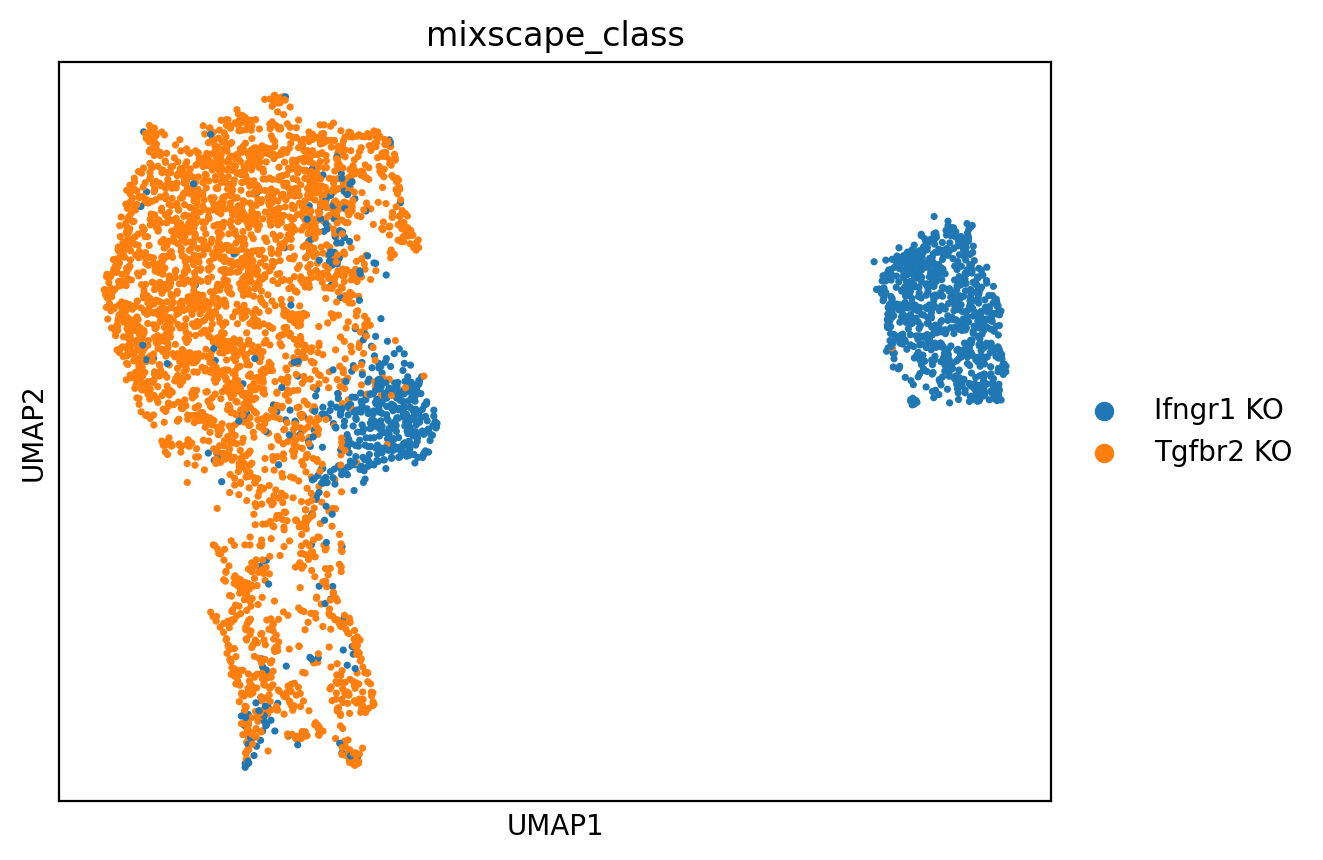

In [42]:
sc.pl.umap(ko_rna, color = "mixscape_class")

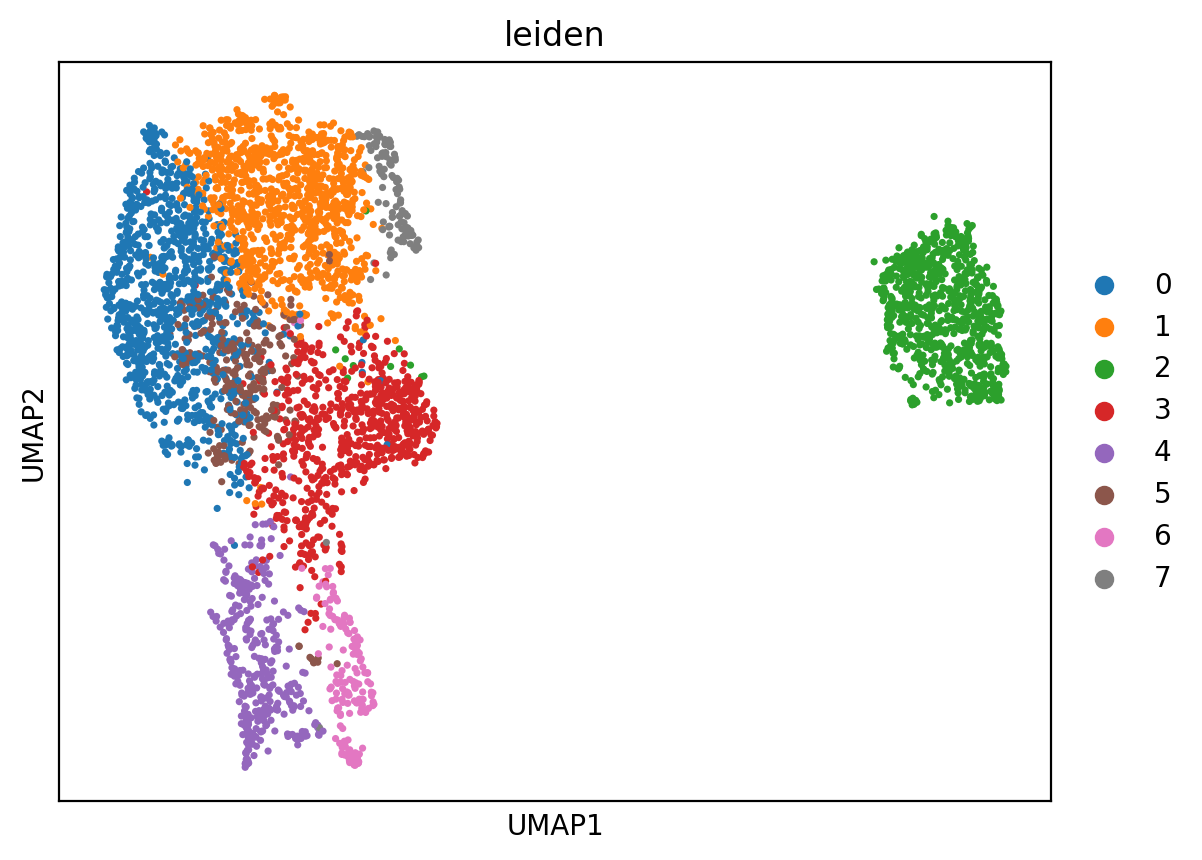

In [43]:
sc.pl.umap(ko_rna, color = "leiden")

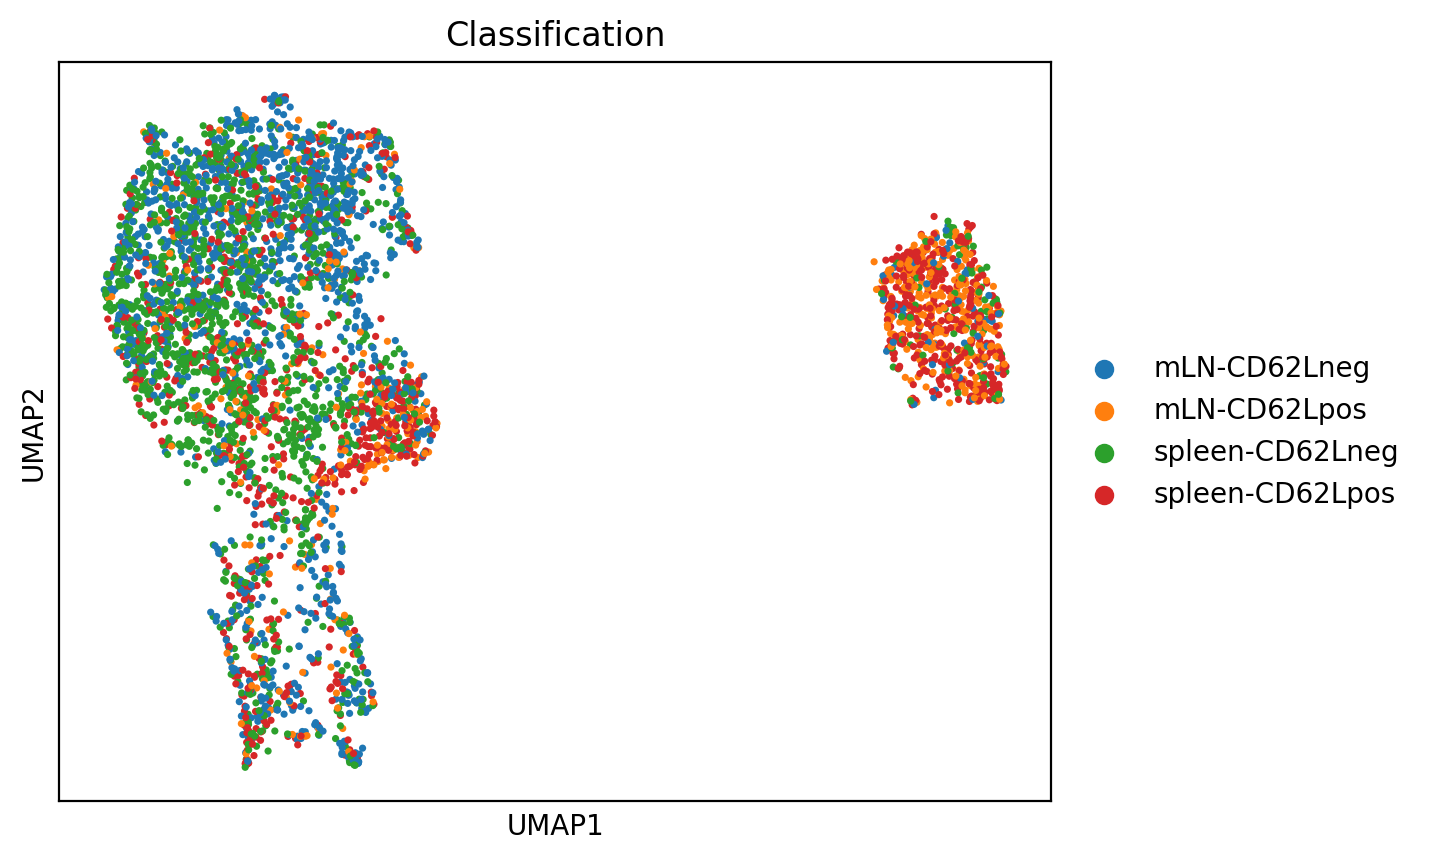

In [44]:
sc.pl.umap(ko_rna, color = "Classification")

In [45]:
ko_rna.obs.head()

,spleen-CD62Lpos,spleen-CD62Lneg,mLN-CD62Lpos,mLN-CD62Lneg,most_likely_hypothesis,cluster_feature,negative_hypothesis_probability,singlet_hypothesis_probability,doublet_hypothesis_probability,Classification,...,num_umis,target,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,mixscape_class_p_ko,mixscape_class,mixscape_class_global,leiden
AAACCAAAGACGTTAT-1,27.0,31.0,7020.0,89.0,1.0,0.0,1.862517e-11,1.000000,2.910459e-08,mLN-CD62Lpos,...,64,Tgfbr2,6195,45470.0,786.0,1.728612,1,Tgfbr2 KO,KO,3
AAACCAAAGGTAGCTC-1,35.0,101.0,4388.0,179.0,1.0,0.0,1.111879e-09,0.999998,2.011029e-06,mLN-CD62Lpos,...,44,Ifngr1,3007,12440.0,258.0,2.073955,1,Ifngr1 KO,KO,2
AAACCAGCAAAATCCC-1,37.0,7374.0,39.0,107.0,1.0,0.0,1.046450e-11,1.000000,8.401979e-08,spleen-CD62Lneg,...,58,Tgfbr2,4505,25348.0,408.0,1.609594,1,Tgfbr2 KO,KO,4
AAACCAGCAACAGAAT-1,24.0,36.0,32.0,13858.0,1.0,0.0,2.772747e-17,1.000000,4.175113e-16,mLN-CD62Lneg,...,405,Tgfbr2,4101,16909.0,241.0,1.425277,1,Tgfbr2 KO,KO,1
AAACCAGCAACCTTAA-1,22.0,9521.0,35.0,90.0,1.0,0.0,6.015559e-13,1.000000,3.100201e-08,spleen-CD62Lneg,...,120,Tgfbr2,4166,16785.0,381.0,2.269884,1,Tgfbr2 KO,KO,0


<Axes: title={'center': 'CD62 composition of Ifgnr1 KO'}, xlabel='Classification'>

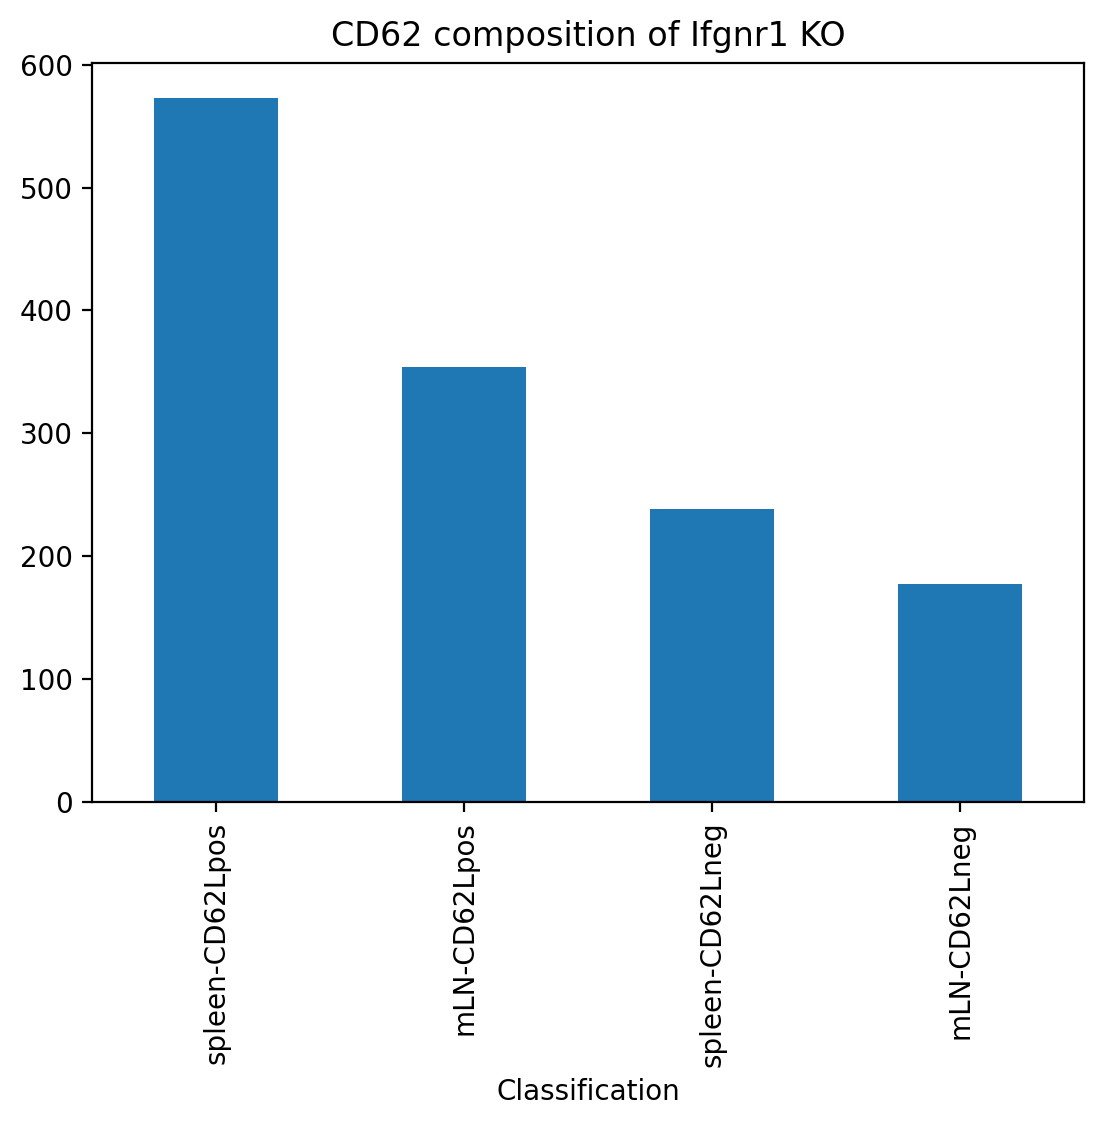

In [46]:
(
    ko_rna
    .obs
    .query("mixscape_class == 'Ifngr1 KO'")
    .Classification
    .value_counts()
    .plot
    .bar(title = "CD62 composition of Ifgnr1 KO")
)

In [47]:
ko_df = ko_rna.obs

In [48]:
ko_df.head()

,spleen-CD62Lpos,spleen-CD62Lneg,mLN-CD62Lpos,mLN-CD62Lneg,most_likely_hypothesis,cluster_feature,negative_hypothesis_probability,singlet_hypothesis_probability,doublet_hypothesis_probability,Classification,...,num_umis,target,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,mixscape_class_p_ko,mixscape_class,mixscape_class_global,leiden
AAACCAAAGACGTTAT-1,27.0,31.0,7020.0,89.0,1.0,0.0,1.862517e-11,1.000000,2.910459e-08,mLN-CD62Lpos,...,64,Tgfbr2,6195,45470.0,786.0,1.728612,1,Tgfbr2 KO,KO,3
AAACCAAAGGTAGCTC-1,35.0,101.0,4388.0,179.0,1.0,0.0,1.111879e-09,0.999998,2.011029e-06,mLN-CD62Lpos,...,44,Ifngr1,3007,12440.0,258.0,2.073955,1,Ifngr1 KO,KO,2
AAACCAGCAAAATCCC-1,37.0,7374.0,39.0,107.0,1.0,0.0,1.046450e-11,1.000000,8.401979e-08,spleen-CD62Lneg,...,58,Tgfbr2,4505,25348.0,408.0,1.609594,1,Tgfbr2 KO,KO,4
AAACCAGCAACAGAAT-1,24.0,36.0,32.0,13858.0,1.0,0.0,2.772747e-17,1.000000,4.175113e-16,mLN-CD62Lneg,...,405,Tgfbr2,4101,16909.0,241.0,1.425277,1,Tgfbr2 KO,KO,1
AAACCAGCAACCTTAA-1,22.0,9521.0,35.0,90.0,1.0,0.0,6.015559e-13,1.000000,3.100201e-08,spleen-CD62Lneg,...,120,Tgfbr2,4166,16785.0,381.0,2.269884,1,Tgfbr2 KO,KO,0


- this looks really good
- looks like the IFNg knockouts tend to be enriched for CD26 which is good because we would expect them to be resting

## Gene enrichment

In [49]:
sc.tl.rank_genes_groups(ko_rna, groupby="mixscape_class")

/lustre/fs4/cao_lab/store/plaffont/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
/lustre/fs4/cao_lab/store/plaffont/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2


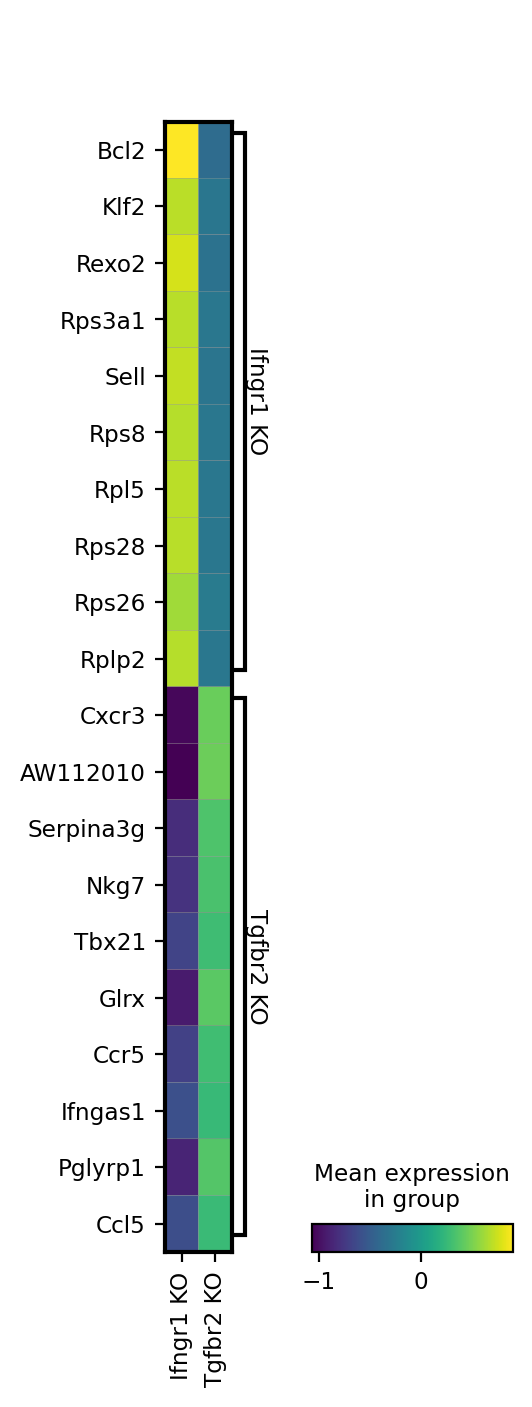

In [50]:
sc.pl.rank_genes_groups_matrixplot(ko_rna, groupby="mixscape_class", swap_axes = True)

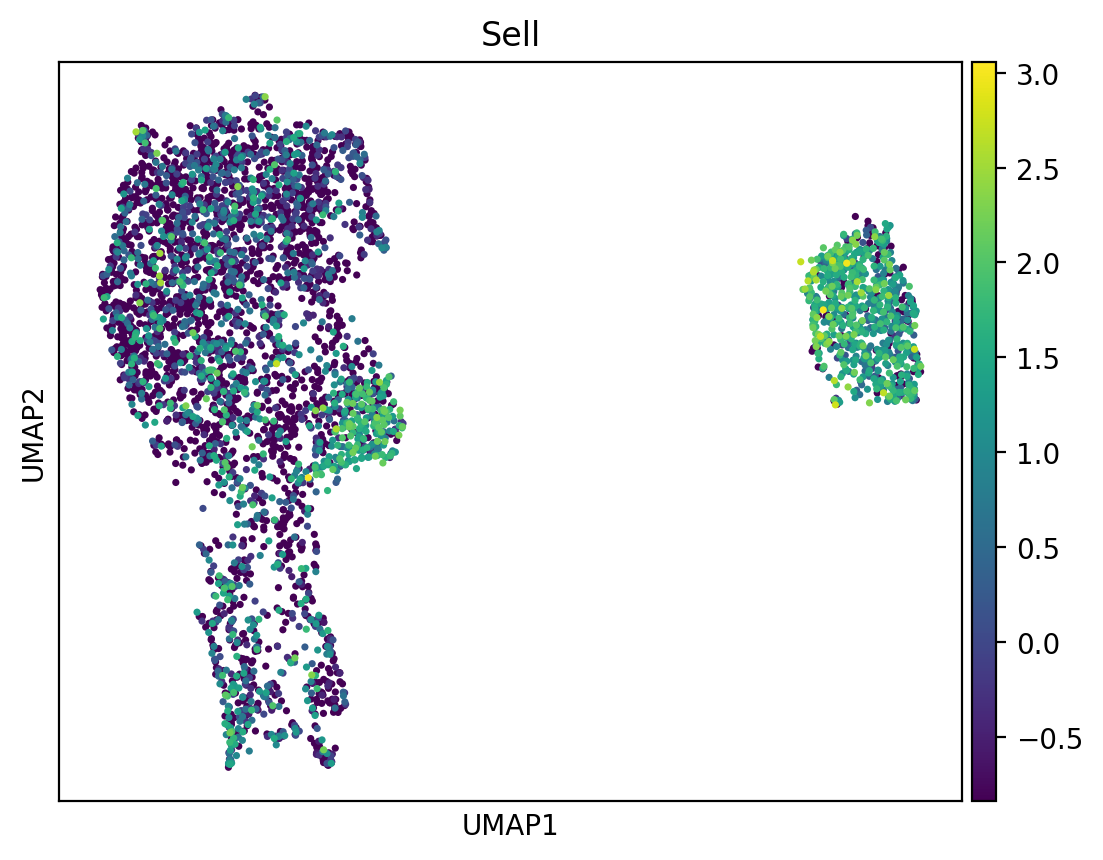

In [51]:
sc.pl.umap(ko_rna, color="Sell")

### Check Cluster DE genes

In [52]:
sc.tl.leiden(ko_rna, resolution = 0.3)

In [53]:
sc.tl.rank_genes_groups(ko_rna, groupby="leiden")

/lustre/fs4/cao_lab/store/plaffont/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
/lustre/fs4/cao_lab/store/plaffont/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
/lustre/fs4/cao_lab/store/plaffont/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
/lustre/fs4/cao_lab/store/plaffont/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
/lustre/fs4/cao_lab/store/plaffont/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2


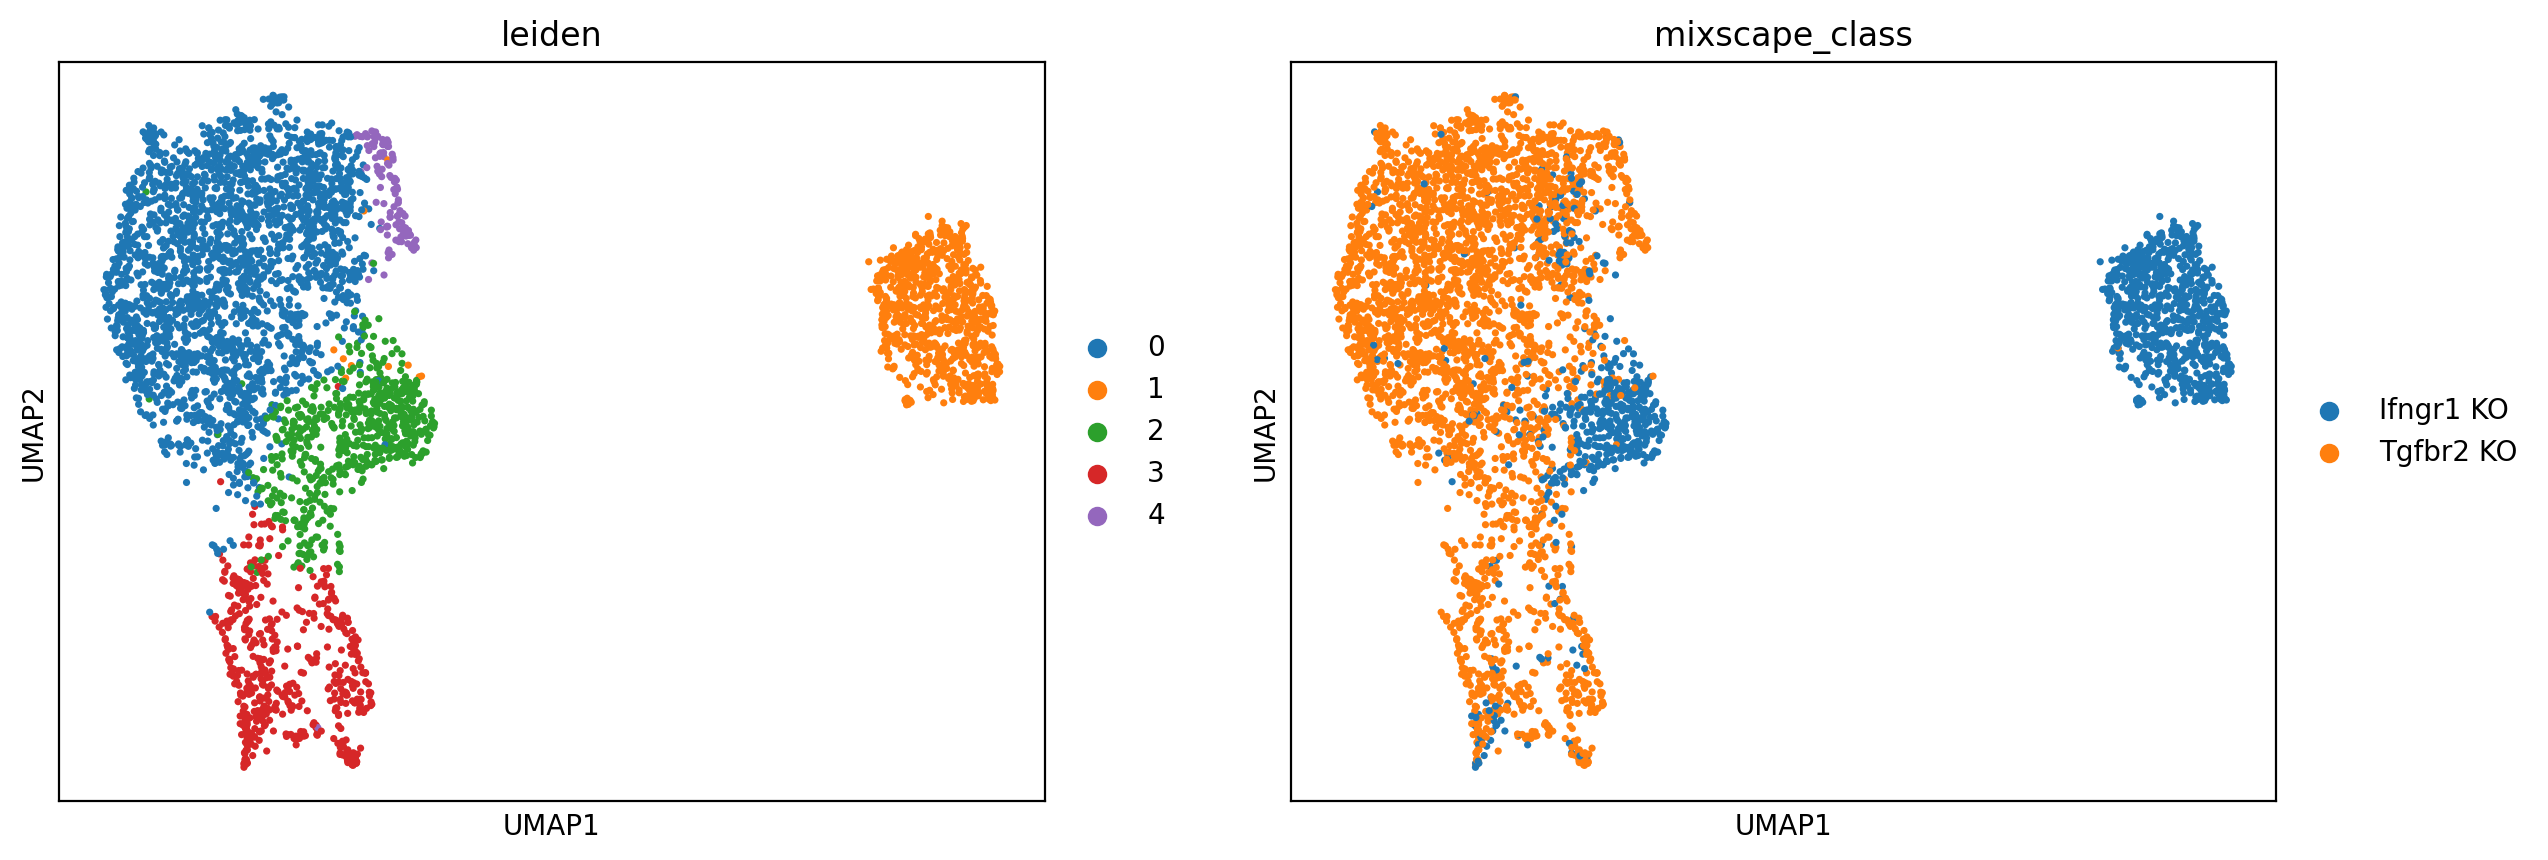

In [54]:
sc.pl.umap(ko_rna, color=["leiden", "mixscape_class"])

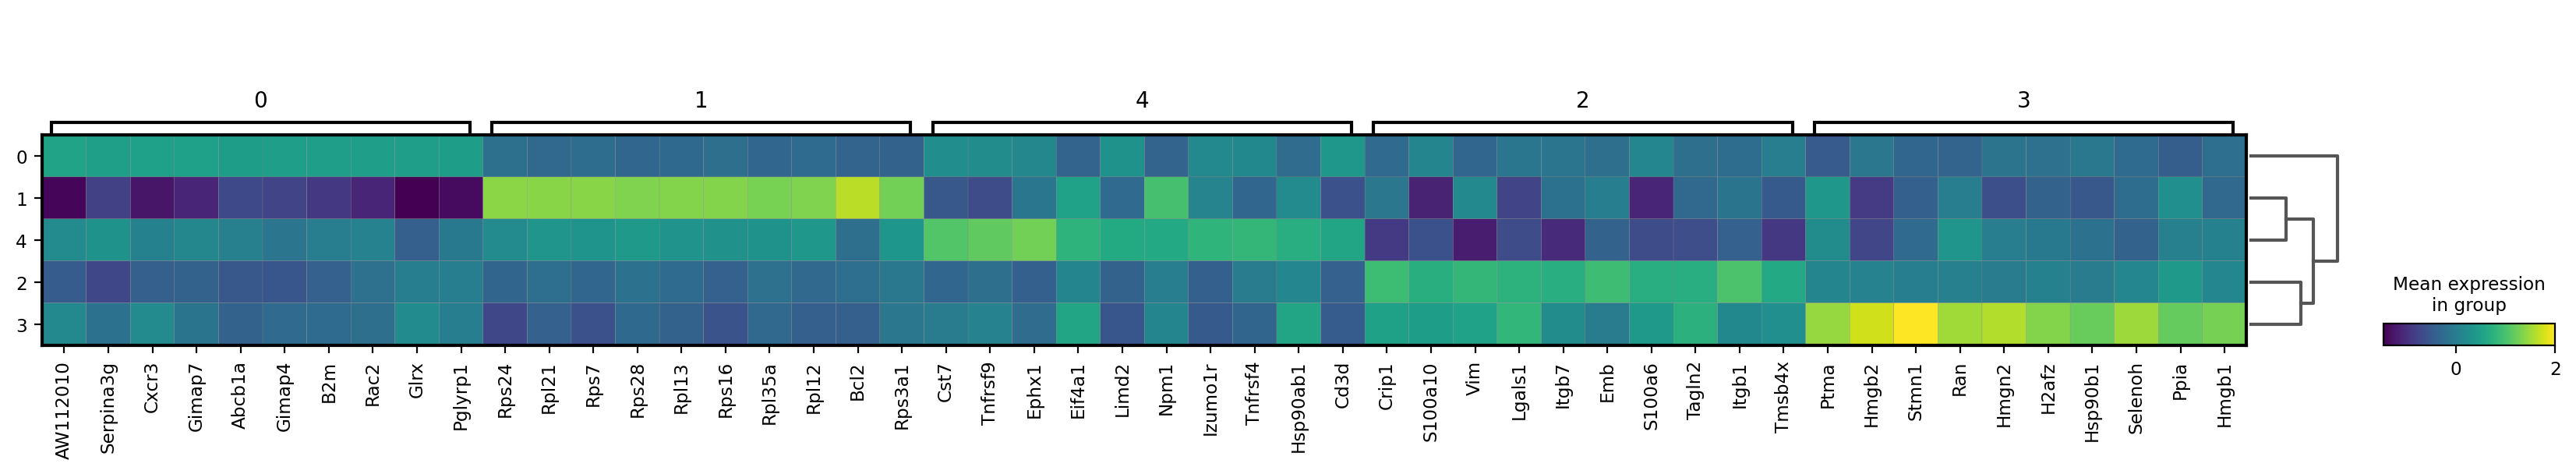

In [55]:
sc.tl.dendrogram(ko_rna, groupby="leiden")
sc.pl.rank_genes_groups_matrixplot(ko_rna, vmax = 2)

### Check the bias

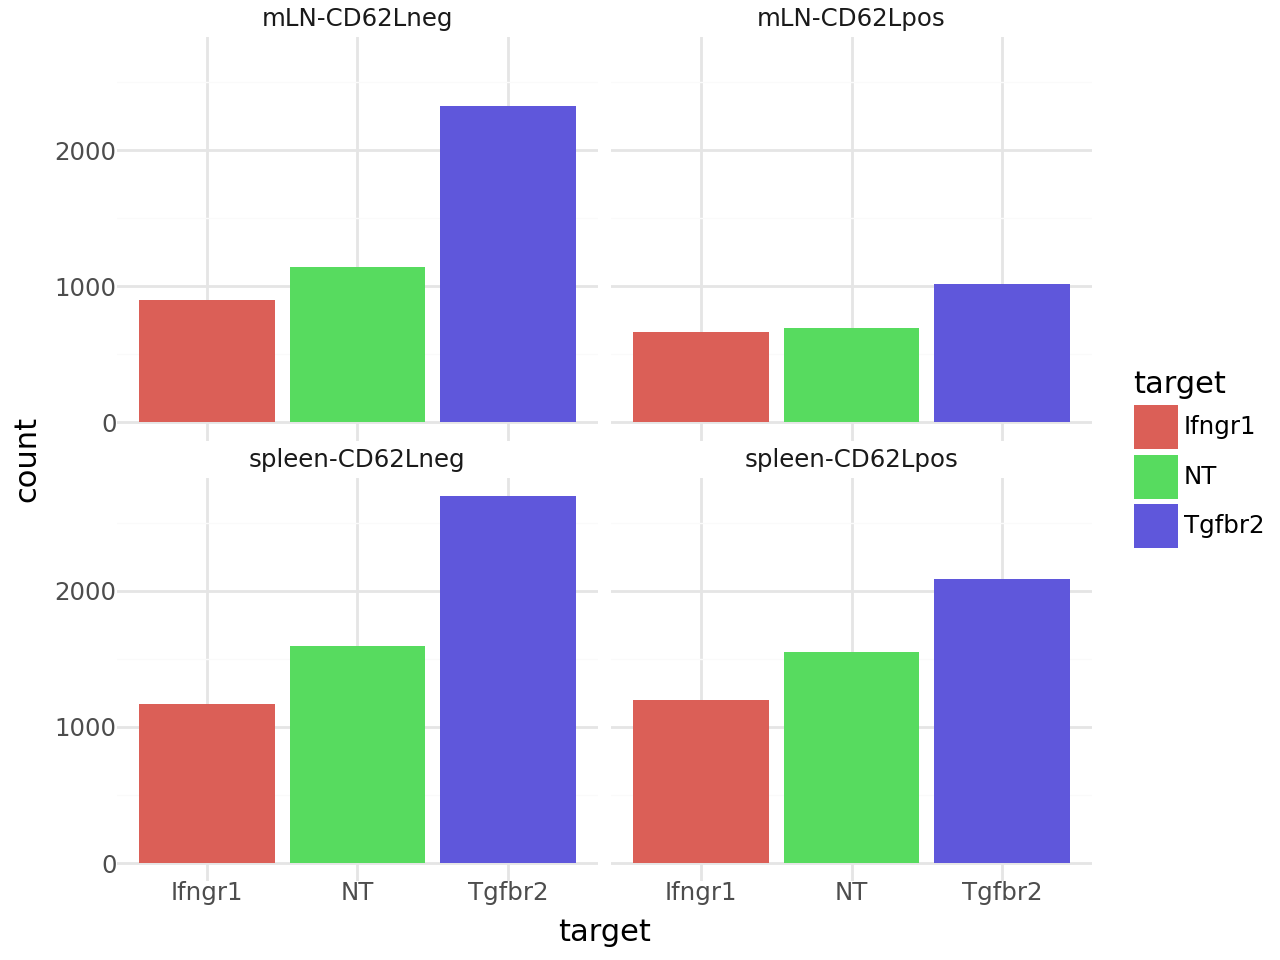

In [56]:
(
    p9.ggplot(rna.obs, p9.aes(x = "target", fill = "target")) +
    p9.geom_bar() +
    p9.facet_wrap("~Classification") +
    p9.theme_minimal()
)